Log Analysis and preparation of data using the raw log file

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

In [107]:
path_to_file = 'HDFS.log'

with open(path_to_file) as input_file:
    hdfs_head = [next(input_file) for _ in range(500000)]

In [108]:
eid_df = pd.read_csv('HDFS.log_templates.csv')

eid_df['regex_pattern'] = (
    eid_df['EventTemplate']
    .str.replace(']', '', regex=False)
    .str.replace('[', '', regex=False)
    .str.replace('*', '(.*?)', regex=False)
)

eid_df

,EventId,EventTemplate,regex_pattern
0,E1,[*]Adding an already existing block[*],(.*?)Adding an already existing block(.*?)
1,E2,[*]Verification succeeded for[*],(.*?)Verification succeeded for(.*?)
2,E3,[*]Served block[*]to[*],(.*?)Served block(.*?)to(.*?)
3,E4,[*]Got exception while serving[*]to[*],(.*?)Got exception while serving(.*?)to(.*?)
4,E5,[*]Receiving block[*]src:[*]dest:[*],(.*?)Receiving block(.*?)src:(.*?)dest:(.*?)
5,E6,[*]Received block[*]src:[*]dest:[*]of size[*],(.*?)Received block(.*?)src:(.*?)dest:(.*?)of size(.*?)
6,E7,[*]writeBlock[*]received exception[*],(.*?)writeBlock(.*?)received exception(.*?)
7,E8,[*]PacketResponder[*]for block[*]Interrupted[*],(.*?)PacketResponder(.*?)for block(.*?)Interrupted(.*?)
8,E9,[*]Received block[*]of size[*]from[*],(.*?)Received block(.*?)of size(.*?)from(.*?)
9,E10,[*]PacketResponder[*]Exception[*],(.*?)PacketResponder(.*?)Exception(.*?)


In [109]:
df_raw = pd.DataFrame(hdfs_head, columns=['raw_log'])

regex_pattern = r'^(?P<Date>\d{6})\s+(?P<Time>\d{6})\s+(?P<Pid>\d+)\s+(?P<Level>\w+)\s+(?P<Component>[^:]+):\s+(?P<Content>.*)$'

df_base = df_raw['raw_log'].str.extract(regex_pattern)

df_base.Content

0                              Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010
1         BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906
2                                  Receiving block blk_-1608999687919862906 src: /10.250.10.6:40524 dest: /10.250.10.6:50010
3                              Receiving block blk_-1608999687919862906 src: /10.250.14.224:42420 dest: /10.250.14.224:50010
4                                                           PacketResponder 1 for block blk_-1608999687919862906 terminating
                                                                 ...                                                        
499995                           10.251.26.177:50010:Got exception while serving blk_6745860875456203032 to /10.251.127.191:
499996                                          10.251.110.196:50010 Served block blk_3093569883558689157 to /10.251.110.196


In [110]:
combined_regex_str = "|".join([f"(?P<{eid}>{pat})" for eid, pat in zip(eid_df['EventId'], eid_df['regex_pattern'])])
combined_pattern = re.compile(combined_regex_str)

# 2. Define a function to extract the name of the group that matched
def get_event_id_fast(content):
    match = combined_pattern.search(content)
    if match:
        # lastgroup returns the name of the named group that participated in the match
        return match.lastgroup
    return None

# 3. Apply to the dataframe
df_base['EventId'] = df_base['Content'].apply(get_event_id_fast)
df_base.head()

,Date,Time,Pid,Level,Component,Content,EventId
0,081109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010,E5
1,081109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906,E22
2,081109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: /10.250.10.6:40524 dest: /10.250.10.6:50010,E5
3,081109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: /10.250.14.224:42420 dest: /10.250.14.224:50010,E5
4,081109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919862906 terminating,E11


In [111]:
df_base['BlockId'] = df_base['Content'].str.extract(r'(blk_-?\d+)')

# Generate all Events into columns
e_matrix2 = pd.crosstab(df_base['BlockId'], df_base['EventId'])
all_event_ids = [f'E{i}' for i in range(1, 30)]
e_matrix2 = e_matrix2.reindex(columns=all_event_ids, fill_value=0)

# Get Highest Level per blockId
block_severity = df_base.groupby('BlockId', as_index=False)['Level'].max()
block_severity.rename(columns={'Level': 'MaxLevel'}, inplace=True)
custom_map = {'INFO': 1, 'WARN': 2, 'ERROR': 3, 'FATAL': 100}
block_severity['MaxLevelNum'] = block_severity['MaxLevel'].map(custom_map)

e_matrix2 = e_matrix2.reset_index().fillna(0)

# Merge with highest level per block
e_matrix2 = pd.merge(e_matrix2, block_severity, on='BlockId', how='inner')
df_base.shape

(500000, 8)

In [117]:
e_matrix2.head()

,BlockId,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E22,E23,E24,E25,E26,E27,E28,E29,MaxLevel,MaxLevelNum
0,blk_-1000083860370843431,0,0,0,0,3,0,0,0,3,...,1,0,0,0,3,0,0,0,INFO,1
1,blk_-1000639647761179183,0,0,1,1,3,0,0,0,3,...,1,0,0,0,3,0,0,0,WARN,2
2,blk_-1000927344760357676,0,0,0,0,3,0,0,0,3,...,1,0,0,0,3,0,0,0,INFO,1
3,blk_-1000974751560899194,0,0,0,0,3,0,0,0,3,...,1,0,0,0,3,0,0,0,INFO,1
4,blk_-1001052357459993016,0,0,0,0,3,0,0,0,3,...,1,0,0,0,3,0,0,0,INFO,1


In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

scaled = StandardScaler()
tree = DecisionTreeClassifier(max_depth=5)

train_df = pd.read_csv('Event_occurrence_matrix.csv')

x = train_df.drop(['BlockId','Label','Type'],axis=1)
y = train_df.Label
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=33)

tree.fit(xtrain, ytrain)
y_pred_tree = tree.predict(xtest)

print(confusion_matrix(ytest, y_pred_tree))
print(classification_report(ytest, y_pred_tree))

[[  3387     15]
 [    18 111593]]
              precision    recall  f1-score   support

        Fail       0.99      1.00      1.00      3402
     Success       1.00      1.00      1.00    111611

    accuracy                           1.00    115013
   macro avg       1.00      1.00      1.00    115013
weighted avg       1.00      1.00      1.00    115013



In [176]:
m = e_matrix2.drop(['BlockId', 'MaxLevel','MaxLevelNum'], axis=1)
d = e_matrix2.MaxLevelNum.map({1:'Success',2:'Fail'})

w = tree.predict(m)

suc =0
fail=0
for ks in w:

    if 'Success' in ks:
        suc+=1
    elif 'Fail' in ks:
        fail+=1
        
print(suc,fail)

35498 807


In [128]:
e_matrix2.MaxLevel.value_counts()


MaxLevel
INFO    29599
WARN     6706
Name: count, dtype: int64

In [146]:
sdf = train_df[['BlockId','Label','Type']]
fhd = pd.merge(e_matrix2, sdf, on='BlockId', how='inner')
fhd[fhd.Label == 'Fail' ].head(20)

,BlockId,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E24,E25,E26,E27,E28,E29,MaxLevel,MaxLevelNum,Label,Type
5,blk_-1001299764911418845,0,0,1,1,3,0,0,0,3,...,0,0,3,0,0,0,WARN,2,Fail,4.0
36,blk_-1018108268208665701,0,0,0,0,3,0,0,0,3,...,0,0,3,0,0,0,INFO,1,Fail,4.0
39,blk_-1018884555287540953,0,0,1,0,3,0,0,0,3,...,0,0,3,0,0,0,INFO,1,Fail,7.0
52,blk_-1023495876047573307,0,0,1,0,4,1,0,0,3,...,0,1,4,0,0,0,INFO,1,Fail,0.0
78,blk_-1038144984524972313,0,0,0,0,3,0,0,0,3,...,0,0,3,0,0,0,INFO,1,Fail,4.0
82,blk_-1038756802570987307,0,0,0,0,3,0,0,0,3,...,0,0,3,0,0,0,INFO,1,Fail,4.0
138,blk_-1063090219742004468,0,0,0,0,2,0,1,0,0,...,0,0,0,0,0,0,INFO,1,Fail,31.0
147,blk_-1067131609371010449,0,0,0,0,4,1,0,0,3,...,0,1,4,0,0,0,WARN,2,Fail,5.0
183,blk_-108581646683624145,0,0,0,0,3,0,0,0,3,...,0,0,3,1,0,0,WARN,2,Fail,1.0
190,blk_-1089874836573056687,0,0,0,0,3,0,0,0,3,...,0,0,3,0,0,0,INFO,1,Fail,4.0


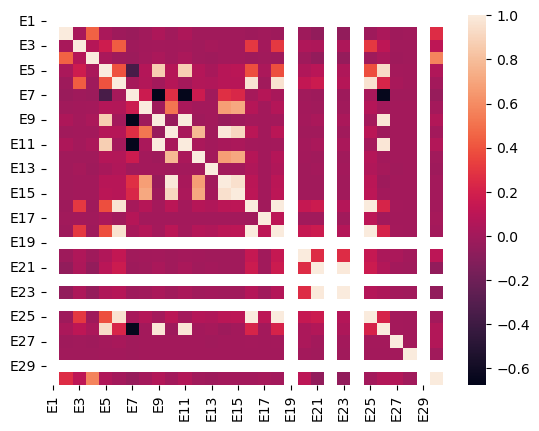

In [148]:
sns.heatmap(e_matrix2.corr(numeric_only=True))
plt.show()

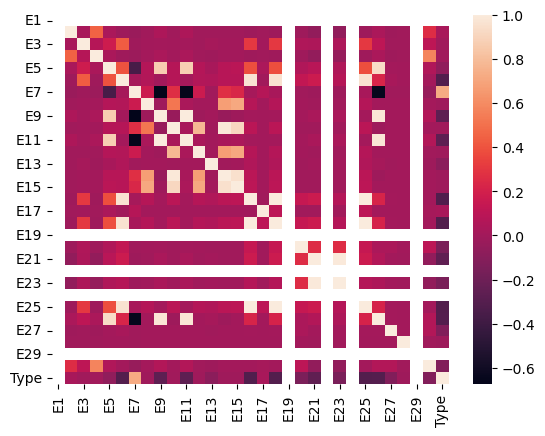

In [147]:
sns.heatmap(fhd.corr(numeric_only=True))
plt.show()

In [59]:
df_extracted_raw['BlockId'] = df_extracted_raw['Content'].str.extract(r'(blk_-?\d+)')



ip_regex = r'src:\s+/(?P<src_ip>[\d\.]+):(?P<src_port>\d+)\s+dest:\s+/(?P<dst_ip>[\d\.]+):(?P<dst_port>\d+)'

ip_details = df_extracted_raw['Content'].str.extract(ip_regex)

final_df = pd.concat([df_extracted_raw,ip_details], axis=1)

final_df.head(10)

,Date,Time,Pid,Level,Component,Content,EventId,BlockId,src_ip,src_port,dst_ip,dst_port
0,081109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010,E5,blk_-1608999687919862906,10.250.19.102,54106,10.250.19.102,50010
1,081109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906,E22,blk_-1608999687919862906,NaN,NaN,NaN,NaN
2,081109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: /10.250.10.6:40524 dest: /10.250.10.6:50010,E5,blk_-1608999687919862906,10.250.10.6,40524,10.250.10.6,50010
3,081109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: /10.250.14.224:42420 dest: /10.250.14.224:50010,E5,blk_-1608999687919862906,10.250.14.224,42420,10.250.14.224,50010
4,081109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919862906 terminating,E11,blk_-1608999687919862906,NaN,NaN,NaN,NaN
5,081109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-1608999687919862906 terminating,E11,blk_-1608999687919862906,NaN,NaN,NaN,NaN
6,081109,203519,145,INFO,dfs.DataNode$PacketResponder,Received block blk_-1608999687919862906 of size 91178 from /10.250.10.6,E9,blk_-1608999687919862906,NaN,NaN,NaN,NaN
7,081109,203519,145,INFO,dfs.DataNode$PacketResponder,Received block blk_-1608999687919862906 of size 91178 from /10.250.19.102,E9,blk_-1608999687919862906,NaN,NaN,NaN,NaN
8,081109,203519,147,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_-1608999687919862906 terminating,E11,blk_-1608999687919862906,NaN,NaN,NaN,NaN
9,081109,203519,147,INFO,dfs.DataNode$PacketResponder,Received block blk_-1608999687919862906 of size 91178 from /10.250.14.224,E9,blk_-1608999687919862906,NaN,NaN,NaN,NaN


In [60]:
final_df.shape

(100000, 12)

In [61]:
final_df.BlockId.nunique()

7940

In [62]:
final_df.Level.value_counts()

Level
INFO    100000
Name: count, dtype: int64

In [67]:
final_df.Level[300]

'INFO'

In [68]:
final_df.EventId.nunique()

16

In [72]:




event_matrix = pd.crosstab(final_df['BlockId'], final_df['EventId'])


all_event_ids = [f'E{i}' for i in range(1, 30)]
event_matrix = event_matrix.reindex(columns=all_event_ids, fill_value=0)

extracted_df = final_df

level_order = ['INFO', 'WARN', 'ERROR', 'FATAL']

# 2. Convert to Categorical (High-speed, low memory)
extracted_df['Level'] = pd.Categorical(
    extracted_df['Level'], 
    categories=level_order, 
    ordered=True
)

# 3. Vectorized GroupBy for BlockId
# as_index=False keeps it as a standard DataFrame
block_severity = extracted_df.groupby('BlockId', as_index=False)['Level'].max()

# 4. Rename for the final report
block_severity.rename(columns={'Level': 'MaxLevel'}, inplace=True)

block_severity

,BlockId,MaxLevel
0,blk_-1001553972418305662,INFO
1,blk_-1010952805175971965,INFO
2,blk_-1011482868748761910,INFO
3,blk_-1011537904811654030,INFO
4,blk_-1015291919896450721,INFO
...,...,...
7935,blk_989409441141247289,INFO
7936,blk_989757635324841895,INFO
7937,blk_992037777600190687,INFO
7938,blk_993316727245644324,INFO


In [81]:
event_matrix.reset_index().fillna(0)

EventId,BlockId,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E20,E21,E22,E23,E24,E25,E26,E27,E28,E29
0,blk_-1001553972418305662,0,0,0,0,3,0,0,0,3,...,0,0,1,0,0,0,3,0,0,0
1,blk_-1010952805175971965,0,0,0,0,3,0,0,0,3,...,0,0,1,0,0,0,3,0,0,0
2,blk_-1011482868748761910,0,0,0,0,3,0,0,0,3,...,0,0,1,0,0,0,3,0,0,0
3,blk_-1011537904811654030,0,0,0,0,3,0,0,0,3,...,0,0,1,0,0,0,3,0,0,0
4,blk_-1015291919896450721,0,0,0,0,3,0,0,0,3,...,0,0,1,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7935,blk_989409441141247289,0,0,0,0,3,0,0,0,3,...,0,0,1,0,0,0,3,0,0,0
7936,blk_989757635324841895,0,0,0,0,3,0,0,0,3,...,0,0,1,0,0,0,3,0,0,0
7937,blk_992037777600190687,0,0,0,0,3,0,0,0,3,...,0,0,1,0,0,0,3,0,0,0
7938,blk_993316727245644324,0,0,0,0,3,0,0,0,3,...,0,0,1,0,0,0,3,0,0,0


In [82]:
    event_matrix = pd.merge(event_matrix, block_severity, on='BlockId', how='inner')

In [83]:
event_matrix

,BlockId,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E21,E22,E23,E24,E25,E26,E27,E28,E29,MaxLevel
0,blk_-1001553972418305662,0,0,0,0,3,0,0,0,3,...,0,1,0,0,0,3,0,0,0,INFO
1,blk_-1010952805175971965,0,0,0,0,3,0,0,0,3,...,0,1,0,0,0,3,0,0,0,INFO
2,blk_-1011482868748761910,0,0,0,0,3,0,0,0,3,...,0,1,0,0,0,3,0,0,0,INFO
3,blk_-1011537904811654030,0,0,0,0,3,0,0,0,3,...,0,1,0,0,0,3,0,0,0,INFO
4,blk_-1015291919896450721,0,0,0,0,3,0,0,0,3,...,0,1,0,0,0,3,0,0,0,INFO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7935,blk_989409441141247289,0,0,0,0,3,0,0,0,3,...,0,1,0,0,0,3,0,0,0,INFO
7936,blk_989757635324841895,0,0,0,0,3,0,0,0,3,...,0,1,0,0,0,3,0,0,0,INFO
7937,blk_992037777600190687,0,0,0,0,3,0,0,0,3,...,0,1,0,0,0,3,0,0,0,INFO
7938,blk_993316727245644324,0,0,0,0,3,0,0,0,3,...,0,1,0,0,0,3,0,0,0,INFO
